In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

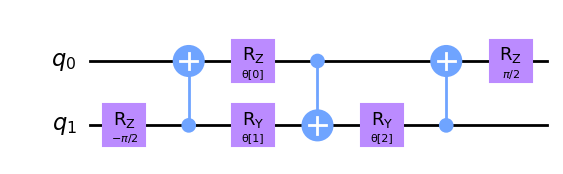

In [4]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

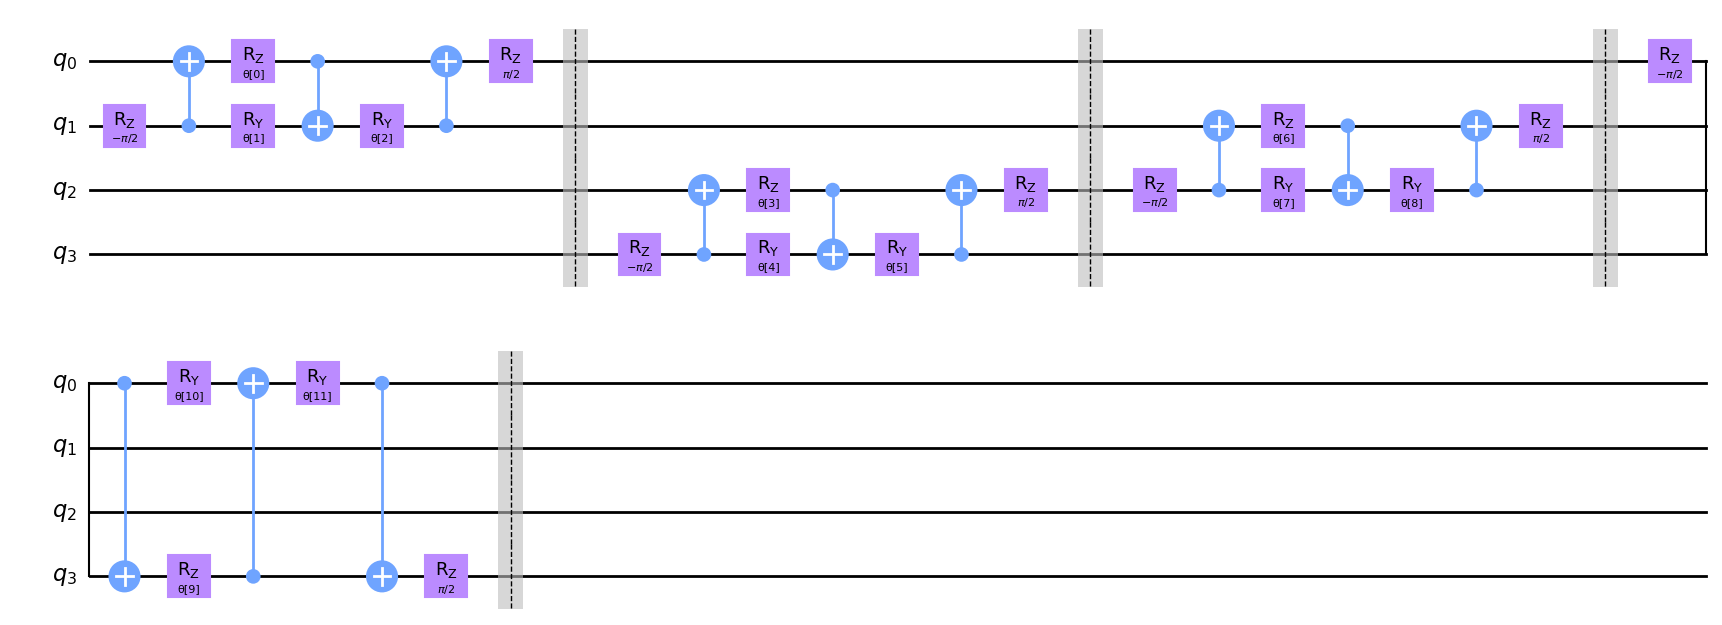

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

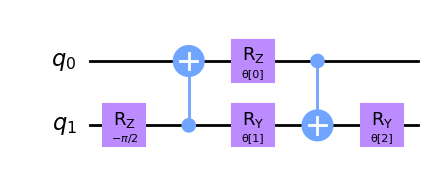

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

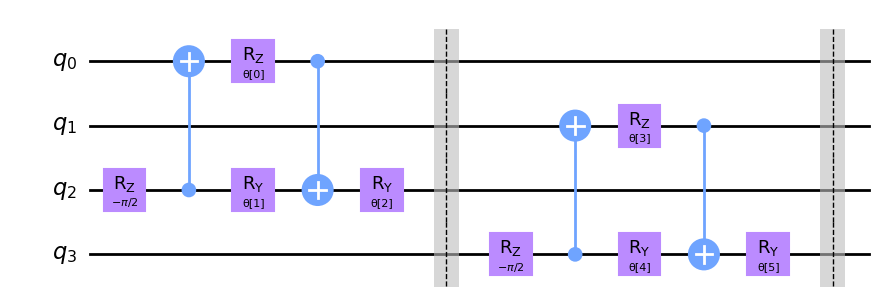

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [10]:

def generate_dataset(num_images):
    images = []
    labels = []

    # Define 8x8 binary digit patterns (0 and 1)
    digit_0 = np.array([
        [0,1,1,1,1,1,1,0],
        [1,1,0,0,0,0,1,1],
        [1,0,0,0,0,0,0,1],
        [1,0,0,0,0,0,0,1],
        [1,0,0,0,0,0,0,1],
        [1,0,0,0,0,0,0,1],
        [1,1,0,0,0,0,1,1],
        [0,1,1,1,1,1,1,0]
    ]) * (np.pi / 2)

    digit_1 = np.array([
        [0,0,0,1,1,0,0,0],
        [0,0,1,1,1,0,0,0],
        [0,1,0,1,1,0,0,0],
        [0,0,0,1,1,0,0,0],
        [0,0,0,1,1,0,0,0],
        [0,0,0,1,1,0,0,0],
        [0,0,0,1,1,0,0,0],
        [0,1,1,1,1,1,1,0]
    ]) * (np.pi / 2)

    for _ in range(num_images):
        label = np.random.choice([0, 1])  # 0 -> digit 0, 1 -> digit 1
        if label == 0:
            base_image = digit_0.copy()
            labels.append(-1)
        else:
            base_image = digit_1.copy()
            labels.append(1)

        # Add slight noise to background (non-line) pixels
        noise_mask = (base_image == 0)
        noise = np.random.uniform(0, np.pi / 4, size=(8, 8))
        base_image[noise_mask] = noise[noise_mask]

        images.append(base_image)

    return images, labels


In [11]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

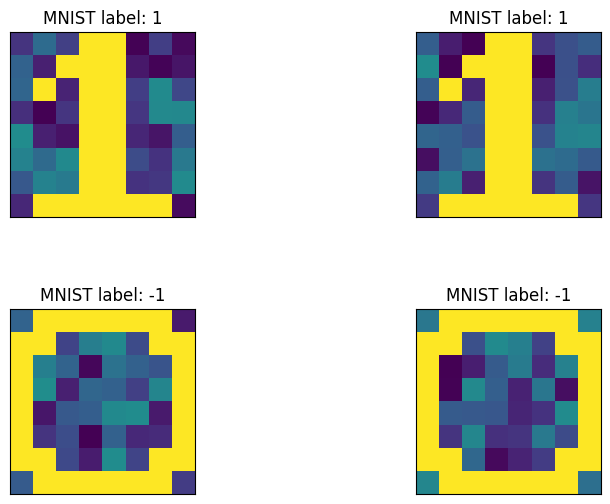

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(train_images[i].reshape(8, 8), aspect="equal")
    ax[i // 2, i % 2].set_title(f"MNIST label: {train_labels[i]}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)


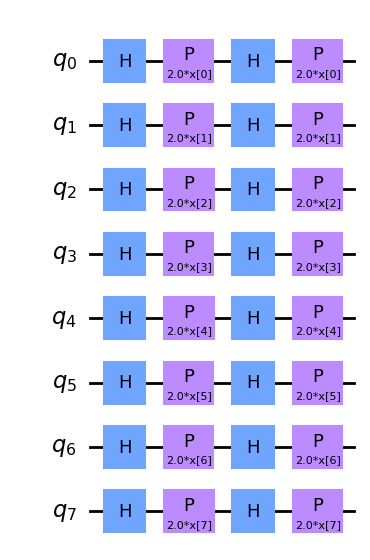

In [13]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [14]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


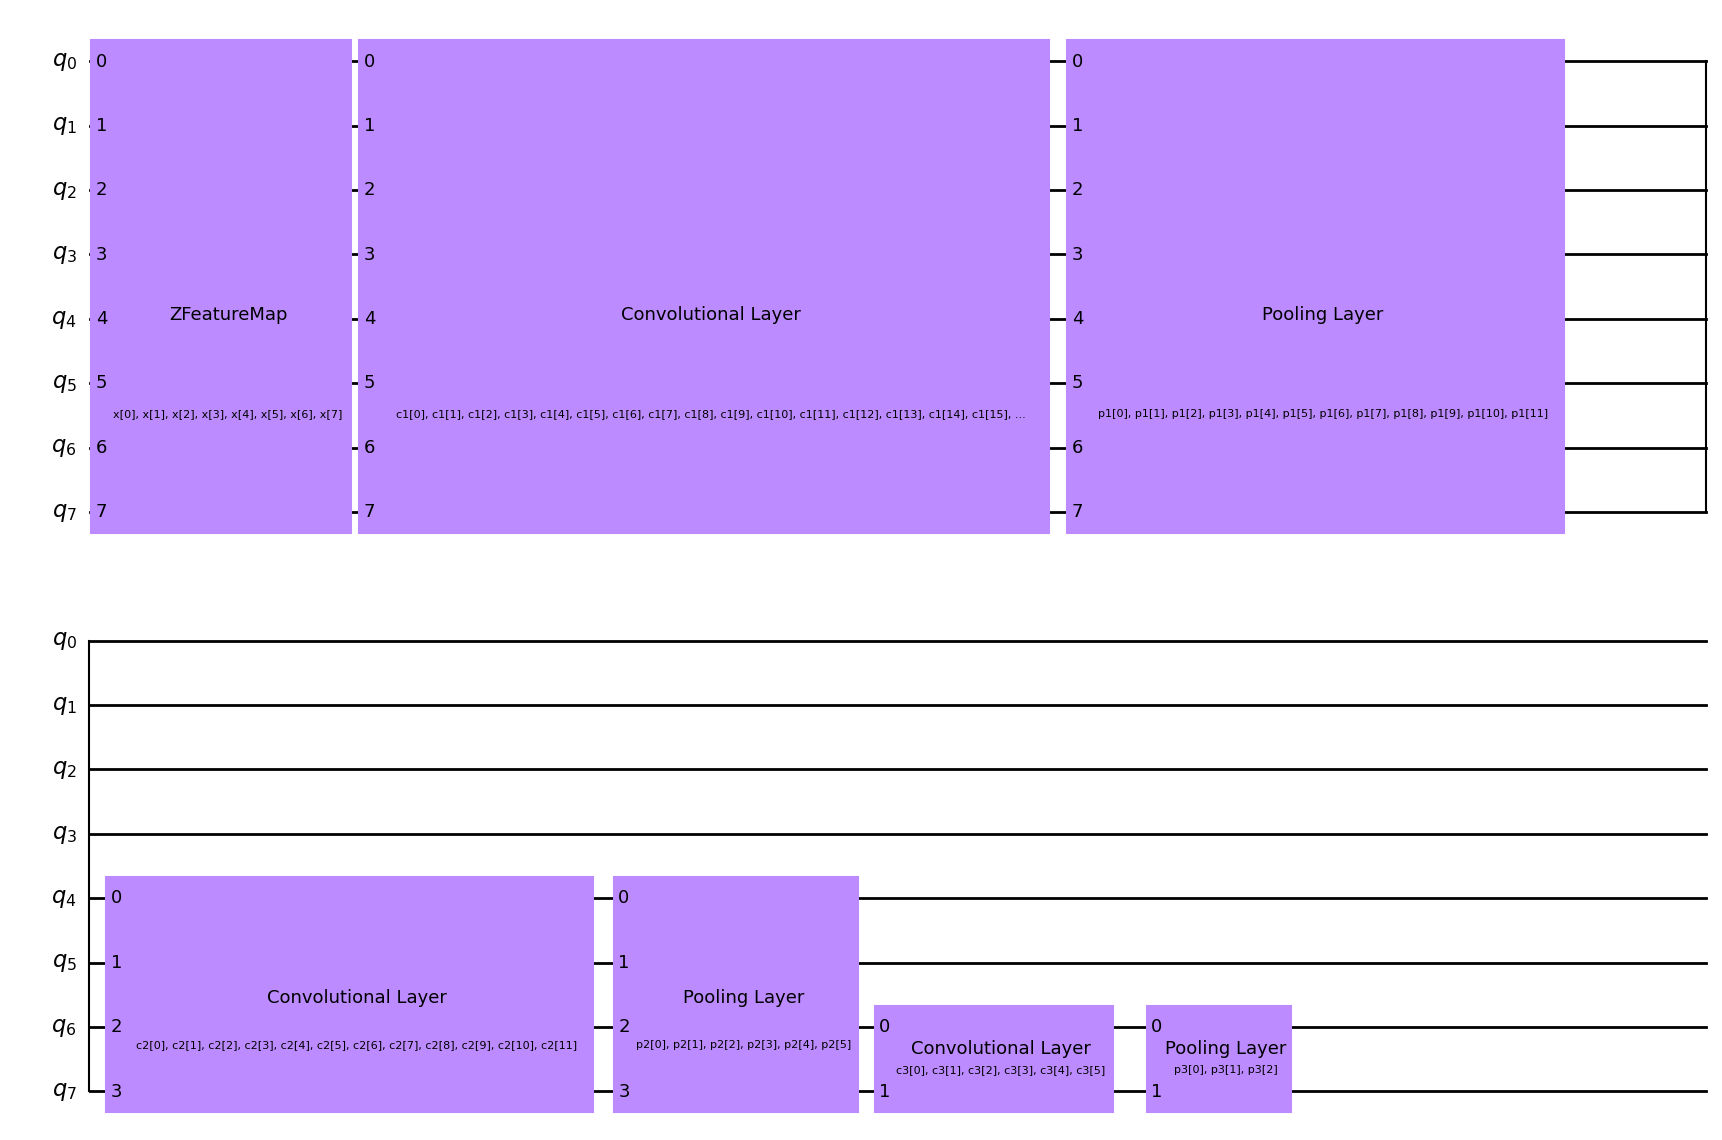

In [15]:
circuit.draw("mpl", style="clifford")

In [16]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [17]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

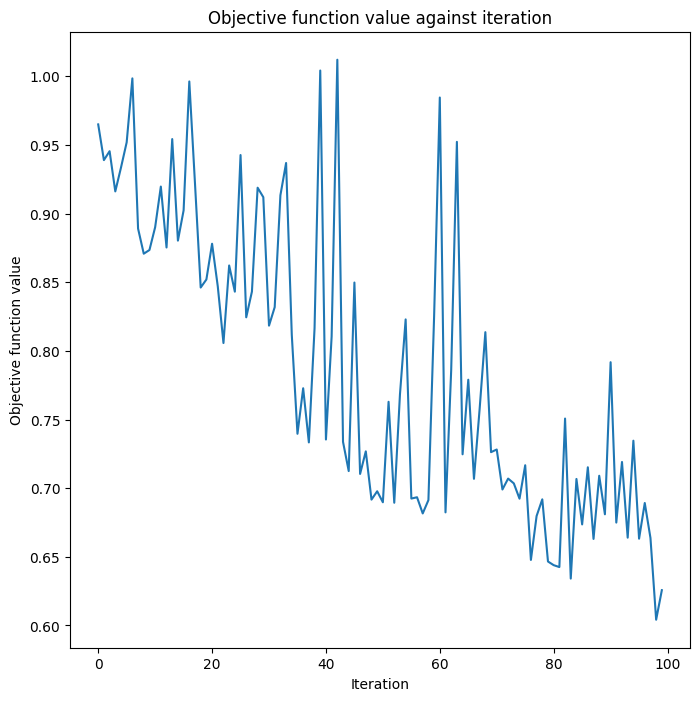

Accuracy from the train data : 100.0%


In [18]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

# Reduce each 8x8 image to a vector of length 8 by taking the mean of each row
x = x.reshape((-1, 8, 8))
x = x.mean(axis=2)  # shape: (n_samples, 8)

print(x.shape[0])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (8, 8)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 96.67%


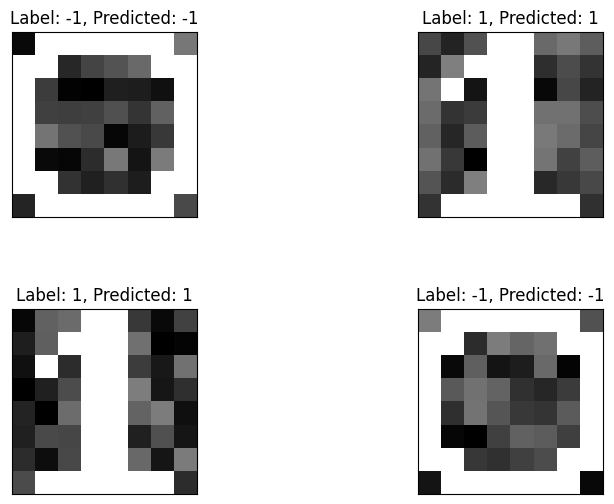

In [19]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
# Reshape test_images to match the input format used during training (mean of each row)
x_test = np.asarray(test_images).reshape((-1, 8, 8))
x_test = x_test.mean(axis=2)  # shape: (n_samples, 8)
y = np.asarray(test_labels)

# Predict using the classifier
y_predict = classifier.predict(x_test)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y), 2)}%")

# Show some examples from the MNIST test set (8x8 images)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(8, 8), cmap="gray", aspect="equal")
    ax[i // 2, i % 2].set_title(f"Label: {test_labels[i]}, Predicted: {int(y_predict[i][0])}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)
